# Natural neighbour interpolation

[Simon Dobson](mailto:simon.dobsoN@st-andrews.ac.uk)<br>
School of Computer Science, University of St Andrews, Scotland UK 

The natural nearest neighbour interpolation method used in developing the CEH-GEAR dataset is a complicated algorithm. In this notebook we conduct a step-by-step development, testing, and optimisation process for the algorithm as described.

In [145]:
from itertools import product
import numpy
from geopandas import GeoDataFrame

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm

from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import shape, Point, Polygon
from shapely.ops import cascaded_union

## Simple Voronoi cells

We will start with the simplest possible arrangement: a square. 

In [2]:
df_frame = GeoDataFrame([Point(0.0, 0.0),
                         Point(0.0, 1.0),
                         Point(1.0, 1.0),
                         Point(1.0, 0.0)], columns=['geometry'])
df_frame

,geometry
0,POINT (0.00000 0.00000)
1,POINT (0.00000 1.00000)
2,POINT (1.00000 1.00000)
3,POINT (1.00000 0.00000)


In this square, we place 4 sample points.

In [3]:
df_points = GeoDataFrame([Point(0.25, 0.25),
                          Point(0.75, 0.25),
                          Point(0.75, 0.75),
                          Point(0.25, 0.75)], columns=['geometry'])
df_points

,geometry
0,POINT (0.25000 0.25000)
1,POINT (0.75000 0.25000)
2,POINT (0.75000 0.75000)
3,POINT (0.25000 0.75000)


The boundary can be turned into a shape simply by taking its co-ordinate points.

In [4]:
df_boundary = GeoDataFrame([Polygon(list(df_frame.geometry))], columns=['geometry'])

boundary_shape = cascaded_union(df_boundary.geometry)
coords = points_to_coords(df_points.geometry)

Using this data. we can now create Voronoi cells around the sample points, which will (unsurprisingly) form squares within the square.  

In [5]:
# create a table of Voronoi cells and their centres
voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
df_voronoi = GeoDataFrame(columns=['centre', 'geometry'])
for i in voronoi_cells.keys():
    df_voronoi.loc[len(df_voronoi.index)] = {'centre': df_points.iloc[voronoi_centres[i][0]].geometry,
                                             'geometry': voronoi_cells[i]}

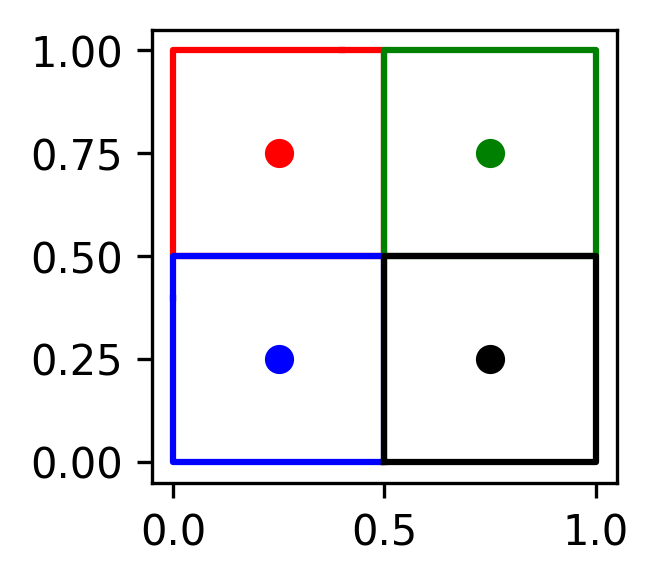

In [6]:
fig = plt.figure(figsize=(2, 2))

colours = ['r', 'g', 'b', 'k']

for i in range(len(df_voronoi)):
    v = df_voronoi.loc[i]
    [(x, y)] = list(v.centre.coords)
    plt.scatter([x], [y], c=colours[i])

    xs, ys = v.geometry.exterior.xy
    plt.plot(xs, ys, c=colours[i])
    
_ = plt.show()

## Sampling and interpolation

We now need to add samples to the points. We do this by creating a new DataFrame with some specific rainfalls at the four sample points. To start with, we'll make everywhere zero apart from one point.

In [146]:
df_rainfall = df_points.copy()
df_rainfall['rainfall'] = [50, 0, 0, 0]
df_rainfall

,geometry,rainfall
0,POINT (0.25000 0.25000),50
1,POINT (0.75000 0.25000),0
2,POINT (0.75000 0.75000),0
3,POINT (0.25000 0.75000),0


This data forms the input to the natural nearest neighbour algorithm. This takes an initial boundary shape and set of sample points, and constructs the Voronoi diagram for them. It then creates "synthetic" sample points at a range of points across the space, and constructs a new Voronoi diagram that includes a synthetic point -- as trhough a sample were taken there. It sets the value at this synthetic point as the weighted sums of the actual samples, weighted by the degree to which the Voronoi cell of trhe synthetic sample points overlaps with those of the underlying "real" cells.

In [8]:
def natural_nearest_neighbour_naive(df_points, boundary_shape, xs, ys):
    '''Interpolate samples given by the df_points `DataFrame`
    at positions given by co-ordinates from xs and ys.
    
    The sample points should be supplied in a `GeoDataFrame` having
    columns `geometry` containing the sample points and `rainfall`
    holding the observation at that point. All the samples should
    lie within the boundary_shape.
    
    The returned `DataFrame` will have columns `geometry` for the
    interpolated points, `x` and `y` for the indices of the observation
    along the two axes, and `rainfall` for the interpolated rainfall.
    
    :param df_points: the samples
    :param boundary_shape: the boundary surrounding the samples
    :param xs: list of x co-ordinates to interpolate at
    :param ys: list of y co-ordinates to interpolate at
    :returns: a dataframe'''
    
    # check that all the sample points lie within the boundary
    if not df_points.geometry.within(boundary_shape).all():
        raise ValueError('At least one point lies on or outside the boundary')
    
    # construct the Voronoi cells around the real sample points
    coords = points_to_coords(df_points.geometry)
    voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
    df_voronoi = GeoDataFrame({'centre': [df_points.iloc[voronoi_centres[i][0]].geometry for i in voronoi_cells.keys()],
                               'geometry': voronoi_cells.values()})

    # construct the interpolation points
    df_interpoints = GeoDataFrame({'x': [i for l in [[j] * len(ys) for j in range(len(xs))] for i in l],
                                   'y': list(range(len(list(ys)))) * len(xs),
                                   'geometry': [Point(x, y) for (x, y) in product(xs, ys)]})

    # perform the interpolation
    interpolated_rainfall = []
    for p in df_interpoints.geometry:
        # add the synthetic point
        synthetic_coords = numpy.append(coords, points_to_coords([p]), axis=0)
        
        # re-compute the Voronoi cells, including the synthetic point
        synthetic_voronoi_cells, synthetic_voronoi_centres = voronoi_regions_from_coords(synthetic_coords, boundary_shape)
    
        # get the synthetic cell
        i = [i for i in synthetic_voronoi_centres.keys() if len(synthetic_coords) - 1 in synthetic_voronoi_centres[i]][0]
        synthetic_cell = synthetic_voronoi_cells[i]
            
        # compute the weighted value
        synthetic_cell_area = synthetic_cell.area
        synthetic_rainfall = 0
        total_area = 0
        for _, r in df_voronoi.iterrows():
            area = r.geometry.intersection(synthetic_cell).area
            total_area += area
            if area > 0.0:
                obs = df_points[df_points.geometry == r.centre].iloc[0].rainfall
                synthetic_rainfall += (area / synthetic_cell_area) * obs
            
        # store synthetic rainfall
        interpolated_rainfall.append(synthetic_rainfall)
        
    # return the interpolated data
    df_interpoints['rainfall'] = interpolated_rainfall
    return df_interpoints

We test the algorithm by sampling from the boundary in a regular grid with 20 samples on a side. 

In [151]:
%%timeit -n1 -r1

df_single = natural_nearest_neighbour_naive(df_rainfall, boundary_shape,
                                            numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

39.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


This results in a GeoDataFrame with the interpolated results in it, which we can turn into an array for easier processing. The array is formed using the sample points as axes.

In [10]:
def interpolation_to_image(df_interpolation):
    '''Return an array of interpolated data.
    
    :param df_interpolation: the interpolated values
    :returns: an array of values'''
    
    # create the array
    im = numpy.zeros((len(df_interpolation.x.unique()), len(df_interpolation.y.unique())))
    
    # populate the array
    for _, r in df_interpolation[['x', 'y', 'rainfall']].iterrows():
        im[int(r.x), int(r.y)] = r.rainfall
        
    return im

Plotting this array results in an interpolated sample with a single "high point" and smoothly decreasing values as we move away from the sampled point (other samples being zero).

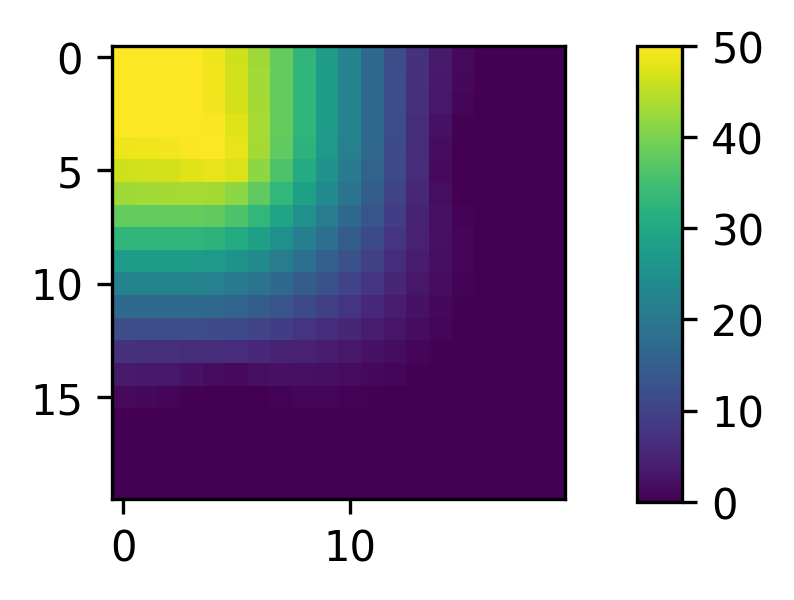

In [155]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df_single), norm=Normalize(min(df.rainfall), max(df.rainfall)))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)

Let's try with another sample set, this time symmetrical across the diagonal.

In [152]:
df_rainfall = df_points.copy()
df_rainfall['rainfall'] = [50, 0, 50, 0]
df_rainfall

,geometry,rainfall
0,POINT (0.25000 0.25000),50
1,POINT (0.75000 0.25000),0
2,POINT (0.75000 0.75000),50
3,POINT (0.25000 0.75000),0


In [153]:
%%timeit -n1 -r1

df_diag = natural_nearest_neighbour_naive(df_rainfall, boundary_shape,
                                          numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

38.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


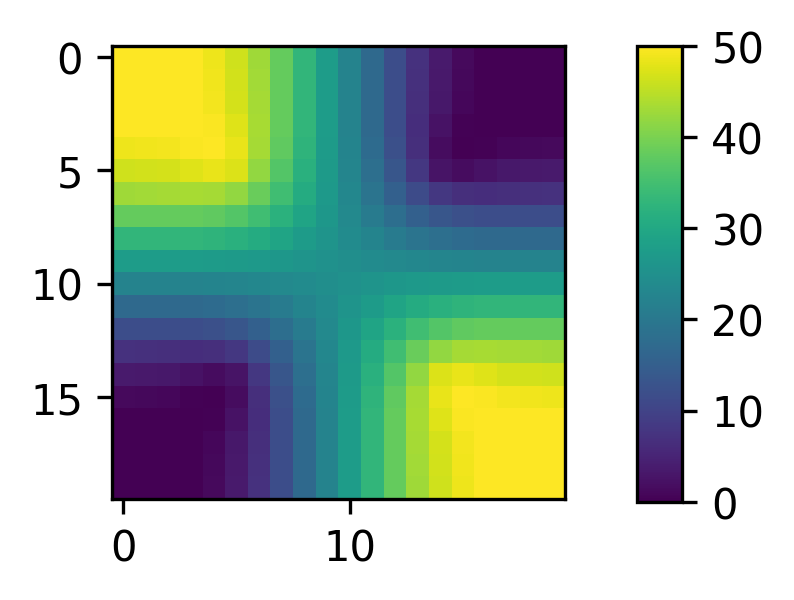

In [154]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df_diag), norm=Normalize(min(df.rainfall), max(df.rainfall)))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)

## A more complex shape

One optimisation we can add to the algorithm is to keep track of the neighbourhoods of each Voronoi cell to reduce the number of intersection calculations needed. This relies on the fact that adding a synthetic interpolation point only causes a local change in the overall Voronoi diagram.

The idea is simple. When interpolating a point $i$, we need to check the cell formed by $i$ against the real cells it overlaps. If $i$ lies in some real cell $c$, then the only cells that it can overlap are those in the neighbourhood of $c$ (including $c$ itself), which we denote $\mathcal{N}_c$. We therefore need only look at intersections with these cells, rather than with all the real cells.

There is a further optimisation in computing the synthetic cells induced by $i$. Since $i$ can affect at most the cells in $\mathcal{N}_c$, we can limit our computations to only these cells; but the boundary of these cells, which we denote $\partial \mathcal{N}_c$, cannot be changed by the formation of a cell around $i$, since the boundary is determined by either the overall boundary of the diagram or by the positions of sample points farther away. We need therefore only re-compute the cells within a fixed boundary  $\partial \mathcal{N}_c$. This can be a radical reduction in the number of calculations.

In [17]:
def natural_nearest_neighbour_faster(df_points, boundary_shape, xs, ys):
    '''Interpolate samples given by the df_points `DataFrame`
    at positions given by co-ordinates from xs and ys.
    
    The sample points should be supplied in a `GeoDataFrame` having
    columns `geometry` containing the sample points and `rainfall`
    holding the observation at that point. All the samples should
    lie within the boundary_shape.
    
    The returned `DataFrame` will have columns `geometry` for the
    interpolated points, `x` and `y` for the indices of the observation
    along the two axes, and `rainfall` for the interpolated rainfall.
    
    :param df_points: the samples
    :param boundary_shape: the boundary surrounding the samples
    :param xs: list of x co-ordinates to interpolate at
    :param ys: list of y co-ordinates to interpolate at
    :returns: a dataframe'''
    
    # check that all the sample points lie within the boundary
    if not df_points.geometry.within(boundary_shape).all():
        raise ValueError('At least one point lies on or outside the boundary')
    
    # construct the real Voronoi cells around the sample points
    coords = points_to_coords(df_points.geometry)
    voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
    df_voronoi = GeoDataFrame({'centre': [df_points.iloc[voronoi_centres[i][0]].geometry for i in voronoi_cells.keys()],
                               'geometry': voronoi_cells.values()})
    
    # add the neighbourhoods of each cell, the indices of the cells
    # that they touch (including the index of the cell itself)
    neighbourhood = []
    for i in range(len(df_voronoi.index)):
        cell = df_voronoi.iloc[i]
        neighbourhood.append(list(df_voronoi[df_voronoi.geometry.touches(cell.geometry)].index) + [i])
    df_voronoi['neighbourhood'] = neighbourhood

    # construct the interpolation points
    df_interpoints = GeoDataFrame({'x': [i for l in [[j] * len(ys) for j in range(len(xs))] for i in l],
                                   'y': list(range(len(list(ys)))) * len(xs),
                                   'geometry': [Point(x, y) for (x, y) in product(xs, ys)]})

    # perform the interpolation
    real_cell = None                 # the real cell the sample point lies in
    df_real_neighbourhood = None     # the real neighbourhood of this real cell, including the cell itself
    real_coords = None               # co-ordinates of the neighhbourhood sample points
    real_boundary_shape = None       # the boundary of the neighbourhood
    interpolated_rainfall = []
    for p in df_interpoints.geometry:
        # check whether this point lies in a differenr real cell to
        # the last point, which will necessitate a change of neighbourhood
        if real_cell is None or not real_cell.intersects(p):
            # yes, re-compute the neighbourhood of Voronoi cells,
            # the only ones that the cell around this sample point
            # can intersect and so the only computation we need to do
            c = df_voronoi[df_voronoi.geometry.intersects(p)]
            real_cell = c.iloc[0].geometry
            df_real_neighbourhood = df_voronoi.loc[df_voronoi.loc[c.index[0]].neighbourhood]
            real_coords = points_to_coords(df_real_neighbourhood.centre)
            real_boundary_shape = cascaded_union(df_real_neighbourhood.geometry)
                
        # re-compute the Voronoi cells
        synthetic_coords = numpy.append(real_coords, points_to_coords([p]), axis=0)
        synthetic_voronoi_cells, synthetic_voronoi_centres = voronoi_regions_from_coords(synthetic_coords, real_boundary_shape)
    
        # get the synthetic cell
        i = [i for i in synthetic_voronoi_centres.keys() if len(synthetic_coords) - 1 in synthetic_voronoi_centres[i]][0]
        synthetic_cell = synthetic_voronoi_cells[i]
            
        # compute the weighted value
        synthetic_cell_area = synthetic_cell.area
        synthetic_rainfall = 0
        total_area = 0
        for _, r in df_real_neighbourhood.iterrows():
            area = r.geometry.intersection(synthetic_cell).area
            total_area += area
            if area > 0.0:
                obs = df_points[df_points.geometry == r.centre].iloc[0].rainfall
                synthetic_rainfall += (area / synthetic_cell_area) * obs
            
        # store synthetic rainfall
        interpolated_rainfall.append(synthetic_rainfall)
        
    # return the interpolated data
    df_interpoints['rainfall'] = interpolated_rainfall
    return df_interpoints

This doesn't actually help in the simple case -- in fact it slows things down, since every cell is always in the neighbourhood of every interpolation point -- so we need a more complicated arrangement to test it. We do this by creating a random scattering of sample points within an area.

In [18]:
complicated = [Point((numpy.random.random() * 0.90) + 0.05,
                     (numpy.random.random() * 0.90) + 0.05) for _ in range(20)]
df_complicated = GeoDataFrame({'geometry': complicated})

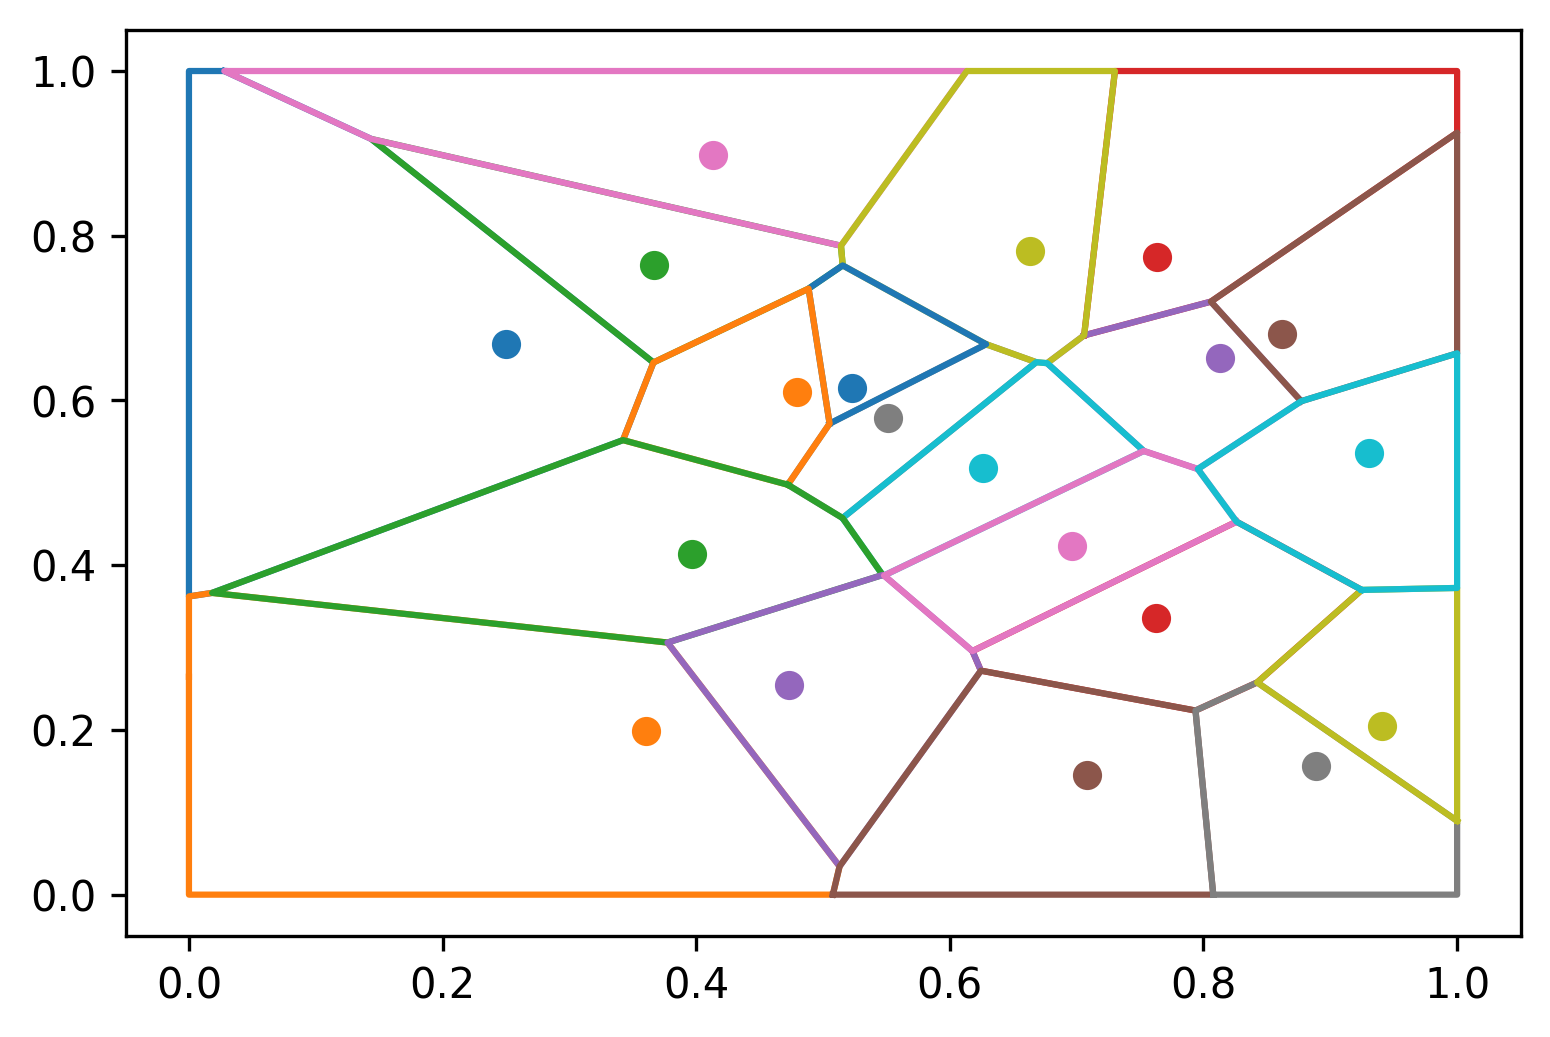

In [19]:
coords = points_to_coords(df_complicated.geometry)
voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
df_voronoi = GeoDataFrame(columns=['centre', 'geometry'])
for i in voronoi_cells.keys():
    df_voronoi.loc[len(df_voronoi.index)] = {'centre': df_complicated.iloc[voronoi_centres[i][0]].geometry,
                                             'geometry': voronoi_cells[i]}

for i in range(len(df_voronoi)):
    v = df_voronoi.loc[i]
    [(x, y)] = list(v.centre.coords)
    plt.scatter([x], [y])

    xs, ys = v.geometry.exterior.xy
    plt.plot(xs, ys)

_ = plt.show()

We can then place some sample values at these points and perform the interpolation.

In [25]:
samples = [0] * len(complicated)
for i in range(int(len(complicated) / 3)):
    j = int(numpy.random.random() * len(complicated))
    samples[j] = numpy.random.random() * 50
df_complicated['rainfall'] = samples

In [156]:
%%timeit -n1 -r1

df_faster = natural_nearest_neighbour_faster(df_complicated, boundary_shape,
                                             numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


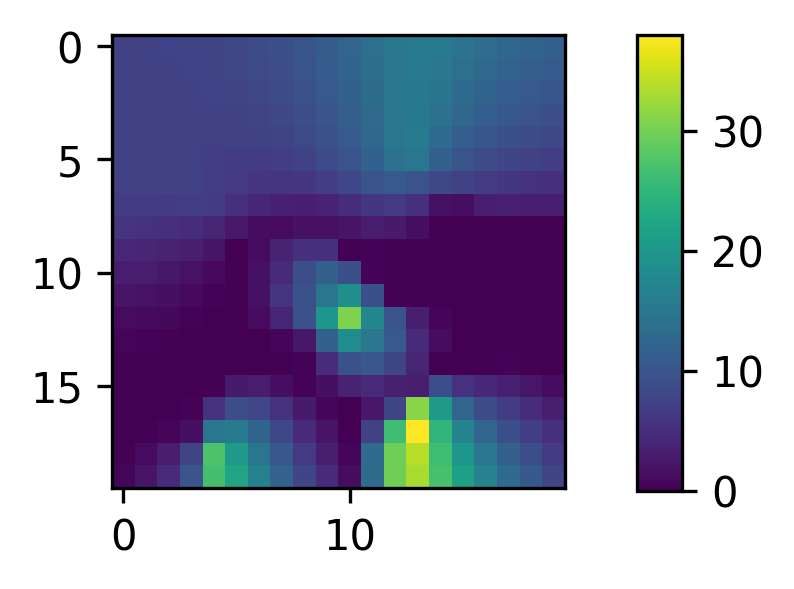

In [27]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df_faster), norm=Normalize(min(df_faster.rainfall),
                                                             max(df_faster.rainfall)))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)

Compared to the naive implementation on thius more complicated sample set we get considerable speed-up.

In [158]:
%%timeit -n1 -r1

df_faster = natural_nearest_neighbour_naive(df_complicated, boundary_shape,
                                            numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

1min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Some more optimisations

There are some further optimisations we can add. Instead of computing the real neighbourhood when a synthetic point cross a cell boundary, we can pre-compute the boundaries for all real cells and thgen retrieve them as necessary to compute a synthetic point. 

In [28]:
def natural_nearest_neighbour_precompute(df_points, boundary_shape, xs, ys):
    '''Interpolate samples given by the df_points `DataFrame`
    at positions given by co-ordinates from xs and ys.
    
    The sample points should be supplied in a `GeoDataFrame` having
    columns `geometry` containing the sample points and `rainfall`
    holding the observation at that point. All the samples should
    lie within the boundary_shape.
    
    The returned `DataFrame` will have columns `geometry` for the
    interpolated points, `x` and `y` for the indices of the observation
    along the two axes, and `rainfall` for the interpolated rainfall.
    
    :param df_points: the samples
    :param boundary_shape: the boundary surrounding the samples
    :param xs: list of x co-ordinates to interpolate at
    :param ys: list of y co-ordinates to interpolate at
    :returns: a dataframe'''
    
    # check that all the sample points lie within the boundary
    if not df_points.geometry.within(boundary_shape).all():
        raise ValueError('At least one point lies on or outside the boundary')
    
    # construct the real Voronoi cells around the sample points
    coords = points_to_coords(df_points.geometry)
    voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
    df_voronoi = GeoDataFrame({'centre': [df_points.iloc[voronoi_centres[i][0]].geometry for i in voronoi_cells.keys()],
                               'geometry': voronoi_cells.values()})
    
    # add the neighbourhoods of each cell, their index and overall boundary
    neighbourhoods = []
    boundaries = []
    for i, cell in df_voronoi.iterrows():
        neighbours = list(df_voronoi[df_voronoi.geometry.touches(cell.geometry)].index) + [i]
        neighbourhoods.append(neighbours)

        # boundary of neighbourhood
        boundaries.append(cascaded_union(df_voronoi.loc[neighbours].geometry))
    df_voronoi['neighbourhood'] = neighbourhoods
    df_voronoi['boundary'] = boundaries
    
    # construct the interpolation points
    df_interpoints = GeoDataFrame({'x': [i for l in [[j] * len(ys) for j in range(len(xs))] for i in l],
                                   'y': list(range(len(list(ys)))) * len(xs),
                                   'geometry': [Point(x, y) for (x, y) in product(xs, ys)]})

    # perform the interpolation
    real_cell = None                 # the real cell the sample point lies in
    df_real_neighbourhood = None     # the real neighbourhood of this real cell, including the cell itself
    real_coords = None               # co-ordinates of the neighhbourhood sample points
    real_boundary_shape = None       # the boundary of the neighbourhood
    interpolated_rainfall = []
    for p in df_interpoints.geometry:
        # check whether this point lies in a different real cell to
        # the last point, which will necessitate a change of neighbourhood
        if real_cell is None or not real_cell.intersects(p):
            # yes,extract the neighbourhood of Voronoi cells,
            # the only ones that the cell around this sample point
            # can intersect and so the only computation we need to do
            i = df_voronoi[df_voronoi.geometry.intersects(p)].index[0]
            df_real_neighbourhood = df_voronoi.loc[df_voronoi.loc[i].neighbourhood]
            real_coords = points_to_coords(df_real_neighbourhood.centre)
            real_boundary_shape = df_voronoi.loc[i].boundary
                
        # re-compute the Voronoi cells
        synthetic_coords = numpy.append(real_coords, points_to_coords([p]), axis=0)
        synthetic_voronoi_cells, synthetic_voronoi_centres = voronoi_regions_from_coords(synthetic_coords, real_boundary_shape)
    
        # get the synthetic cell
        i = [i for i in synthetic_voronoi_centres.keys() if len(synthetic_coords) - 1 in synthetic_voronoi_centres[i]][0]
        synthetic_cell = synthetic_voronoi_cells[i]
            
        # compute the weighted value
        synthetic_cell_area = synthetic_cell.area
        synthetic_rainfall = 0
        total_area = 0
        for _, r in df_real_neighbourhood.iterrows():
            area = r.geometry.intersection(synthetic_cell).area
            total_area += area
            if area > 0.0:
                obs = df_points[df_points.geometry == r.centre].iloc[0].rainfall
                synthetic_rainfall += (area / synthetic_cell_area) * obs
            
        # store synthetic rainfall
        interpolated_rainfall.append(synthetic_rainfall)
        
    # return the interpolated data
    df_interpoints['rainfall'] = interpolated_rainfall
    return df_interpoints

In [157]:
%%timeit -n1 -r1

df_precompute = natural_nearest_neighbour_precompute(df_complicated, boundary_shape,
                                                     numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

41.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


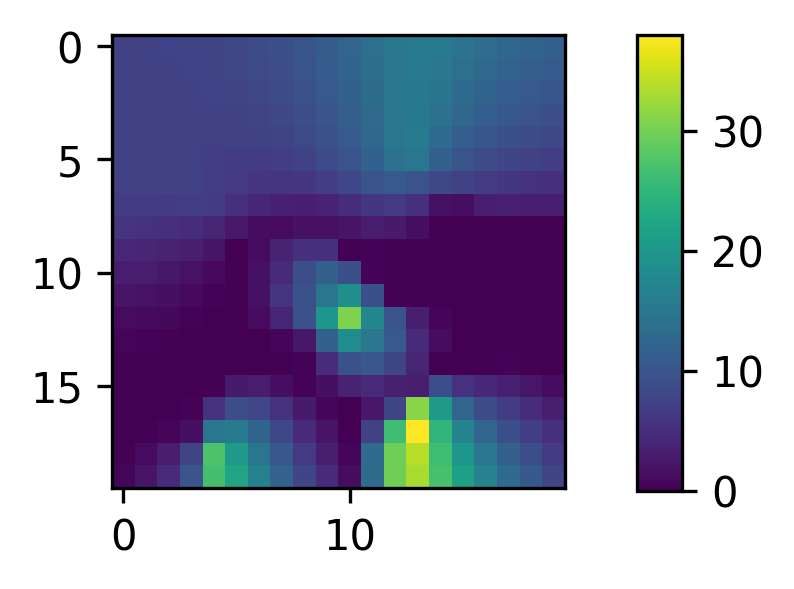

In [30]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df_precompute), norm=Normalize(min(df_precompute.rainfall),
                                                                 max(df_precompute.rainfall)))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)

This approach still has an inefficiency, in that it visits the synthetic points in grid order. This means that the neighbourhood changes more often than is necssary: it would be more efficient to traverse the synthetic points in cell order -- all the points within each cell -- so as to minimise changes.

In [37]:
def natural_nearest_neighbour_ingridorder(df_points, boundary_shape, xs, ys):
    '''Interpolate samples given by the df_points `DataFrame`
    at positions given by co-ordinates from xs and ys.
    
    The sample points should be supplied in a `GeoDataFrame` having
    columns `geometry` containing the sample points and `rainfall`
    holding the observation at that point. All the samples should
    lie within the boundary_shape.
    
    The returned `DataFrame` will have columns `geometry` for the
    interpolated points, `x` and `y` for the indices of the observation
    along the two axes, and `rainfall` for the interpolated rainfall.
    
    :param df_points: the samples
    :param boundary_shape: the boundary surrounding the samples
    :param xs: list of x co-ordinates to interpolate at
    :param ys: list of y co-ordinates to interpolate at
    :returns: a dataframe'''
    
    # check that all the sample points lie within the boundary
    if not df_points.geometry.within(boundary_shape).all():
        raise ValueError('At least one point lies on or outside the boundary')
    
    # construct the real Voronoi cells around the sample points
    coords = points_to_coords(df_points.geometry)
    voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
    df_voronoi = GeoDataFrame({'centre': [df_points.iloc[voronoi_centres[i][0]].geometry for i in voronoi_cells.keys()],
                               'geometry': voronoi_cells.values()})
    
    # add the neighbourhoods of each cell, their index and overall boundary
    neighbourhoods = []
    boundaries = []
    for i, cell in df_voronoi.iterrows():
        neighbours = list(df_voronoi[df_voronoi.geometry.touches(cell.geometry)].index) + [i]
        neighbourhoods.append(neighbours)

        # boundary of neighbourhood
        boundaries.append(cascaded_union(df_voronoi.loc[neighbours].geometry))
    df_voronoi['neighbourhood'] = neighbourhoods
    df_voronoi['boundary'] = boundaries
    
    # construct the interpolation points, including the cell the point lies in
    df_interpoints = GeoDataFrame({'x': [i for l in [[j] * len(ys) for j in range(len(xs))] for i in l],
                                   'y': list(range(len(list(ys)))) * len(xs),
                                   'geometry': [Point(x, y) for (x, y) in product(xs, ys)]})
    cells = []
    for _, cell in df_interpoints.iterrows():
        cells.append(df_voronoi[df_voronoi.geometry.intersects(cell.geometry)].geometry.index[0])
    df_interpoints['cell'] = cells
    
    # perform the interpolation
    interpoints_grouped = df_interpoints.groupby('cell').groups
    interpolated_rainfall = []
    for real_cell in interpoints_grouped.keys():
        # extract the neighbourhood of Voronoi cells,
        # the only ones that the cell around this sample point
        # can intersect and so the only computation we need to do
        df_real_neighbourhood = df_voronoi.loc[df_voronoi.loc[real_cell].neighbourhood]
        real_coords = points_to_coords(df_real_neighbourhood.centre)
        real_boundary_shape = df_voronoi.loc[real_cell].boundary
        
        for pt in interpoints_grouped[real_cell]:
            # re-compute the Voronoi cells
            p = df_interpoints.loc[pt].geometry
            synthetic_coords = numpy.append(real_coords, points_to_coords([p]), axis=0)
            synthetic_voronoi_cells, synthetic_voronoi_centres = voronoi_regions_from_coords(synthetic_coords, real_boundary_shape)
    
            # get the synthetic cell
            i = [i for i in synthetic_voronoi_centres.keys() if len(synthetic_coords) - 1 in synthetic_voronoi_centres[i]][0]
            synthetic_cell = synthetic_voronoi_cells[i]
            
            # compute the weighted value
            synthetic_cell_area = synthetic_cell.area
            synthetic_rainfall = 0
            total_area = 0
            for _, r in df_real_neighbourhood.iterrows():
                area = r.geometry.intersection(synthetic_cell).area
                total_area += area
                if area > 0.0:
                    obs = df_points[df_points.geometry == r.centre].iloc[0].rainfall
                    synthetic_rainfall += (area / synthetic_cell_area) * obs
            
            # store synthetic rainfall
            interpolated_rainfall.append(synthetic_rainfall)
        
    # wrangle the interpolated data into the correct order, drop
    # internal working information, and return
    interpolated_points_in_order = [p for ps in [interpoints_grouped[g] for g in interpoints_grouped.keys()] for p in ps]
    df = df_interpoints.loc[interpolated_points_in_order]
    df['rainfall'] = interpolated_rainfall
    return df.drop['cell']

In [159]:
%%timeit -n1 -r1

df_ingridorder = natural_nearest_neighbour_ingridorder(df_complicated, boundary_shape,
                                                       numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

42.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


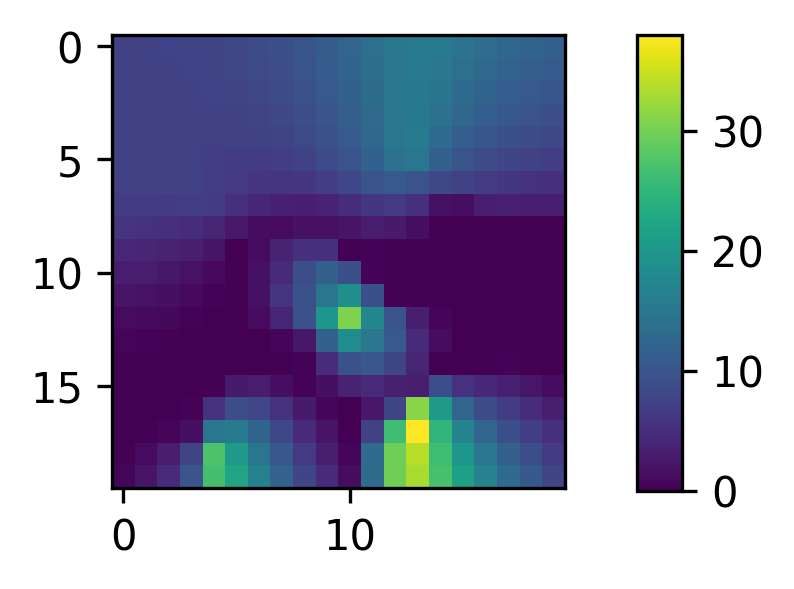

In [39]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df_ingridorder), norm=Normalize(min(df_ingridorder.rainfall),
                                                                  max(df_ingridorder.rainfall)))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)

We can also test with a simpler rainfall on the complex grid. 

In [42]:
df_struct = df_complicated.copy()
samples = [0] * len(complicated)
samples[0] = 60
samples[-1] = 40
samples[10] = 10
df_struct['rainfall'] = samples

In [43]:
df_simpler = natural_nearest_neighbour_ingridorder(df_struct, boundary_shape,
                                                   numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

Plotted on a log scale for better differentiation, this gives:

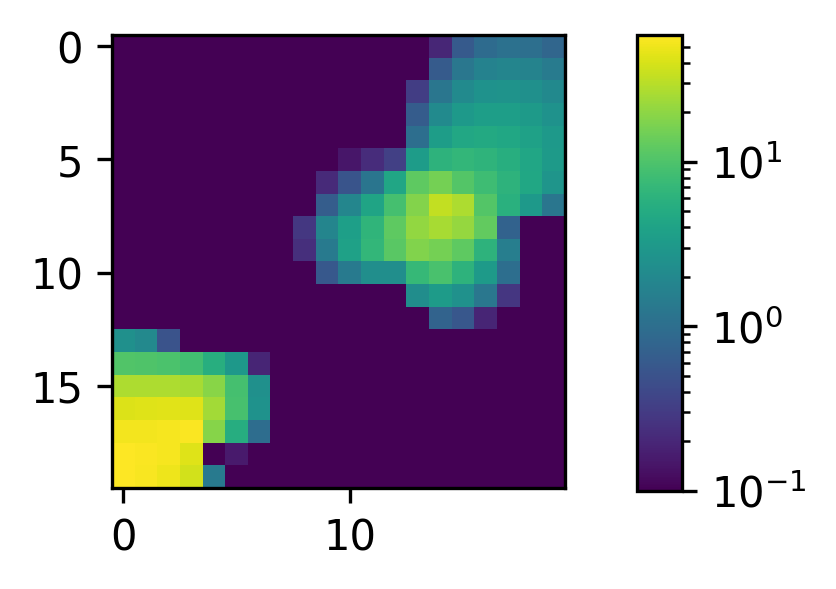

In [172]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df_simpler), norm=LogNorm(min(df_simpler.rainfall) + 0.1,
                                                            max(df_simpler.rainfall), clip=True))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)

## Clearing up the decomposition

We can now tidy-up and refactor the implementation.

In [168]:
def voronoi_from_samples(df_points, boundary_shape):
    '''Construct a table ot Voronoi cells and their adjacencies based on
    a set of samples and a boundary.''
        
    The sample points should be supplied in a `GeoDataFrame` having
    columns `geometry` containing the sample points and `rainfall`
    holding the observation at that point. All the samples should
    lie within the boundary_shape.
    
    The returned `DataFrame` will contain the `geometry` of each cell,
    it's `centre`1 (the sample point it surrounds), a `neighbourhood`
    holding the indices of the cells that intersect this cell (including
    the index of the cell itself), and a `boundary` holding the outer
    boundary of this set.
    
    :param df_points: the samples
    :param boundary_shape: the boundary surrounding the samples
    :returns: a dataframe'''
    coords = points_to_coords(df_points.geometry)
    voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
    df_voronoi = GeoDataFrame({'centre': [df_points.iloc[voronoi_centres[i][0]].geometry for i in voronoi_cells.keys()],
                               'geometry': voronoi_cells.values()})
    
    # add the neighbourhoods of each cell, their index and overall boundary
    neighbourhoods = []
    boundaries = []
    for i, cell in df_voronoi.iterrows():
        neighbours = list(df_voronoi[df_voronoi.geometry.touches(cell.geometry)].index) + [i]
        neighbourhoods.append(neighbours)

        # boundary of neighbourhood
        boundaries.append(cascaded_union(df_voronoi.loc[neighbours].geometry))
    df_voronoi['neighbourhood'] = neighbourhoods
    df_voronoi['boundary'] = boundaries

    return df_voronoi


def interpolation_grid(xs, ys, df_points, df_voronoi):
    '''Construct the grid of interpolation points from a set of samples,
    a set of their voronoi cells, and the sample point axes.

    The returned `DataFrame` will have columns `geometry` for the
    interpolated points, `x` and `y` for the indices of the observation
    along the two axes, and `cell` holding the index of the Voronoi cell
    within which the interpolation point lies.

    :param xs: list of x co-ordinates to interpolate at
    :param ys: list of y co-ordinates to interpolate at
    :param df_points: the samples
    :param df_voronoi: the Voronoi cells for these samples
    :returns: a dataframe'''
    df_interpoints = GeoDataFrame({'x': [i for l in [[j] * len(ys) for j in range(len(xs))] for i in l],
                                   'y': list(range(len(list(ys)))) * len(xs),
                                   'geometry': [Point(x, y) for (x, y) in product(xs, ys)]})
    cells = []
    for _, cell in df_interpoints.iterrows():
        cells.append(df_voronoi[df_voronoi.geometry.intersects(cell.geometry)].geometry.index[0])
    df_interpoints['cell'] = cells

    return df_interpoints

    
def natural_nearest_neighbour(df_points, boundary_shape, xs, ys):
    '''Interpolate samples given by the df_points `DataFrame`
    at positions given by co-ordinates from xs and ys.
    
    The sample points should be supplied in a `GeoDataFrame` having
    columns `geometry` containing the sample points and `rainfall`
    holding the observation at that point. All the samples should
    lie within the boundary_shape.
    
    The returned `DataFrame` will have columns `geometry` for the
    interpolated points, `x` and `y` for the indices of the observation
    along the two axes, and `rainfall` for the interpolated rainfall.
    
    :param df_points: the samples
    :param boundary_shape: the boundary surrounding the samples
    :param xs: list of x co-ordinates to interpolate at
    :param ys: list of y co-ordinates to interpolate at
    :returns: a dataframe'''
    
    # check that all the sample points lie within the boundary
    if not df_points.geometry.within(boundary_shape).all():
        raise ValueError('At least one point lies on or outside the boundary')
    
    # construct the real Voronoi cells around the sample points
    df_voronoi = voronoi_from_samples(df_points, boundary_shape)
    
    # construct the interpolation grid
    df_interpoints = interpolation_grid(xs, ys, df_points, df_voronoi)
    
    # perform the interpolation
    interpoints_grouped = df_interpoints.groupby('cell').groups
    interpolated_rainfall = []
    for real_cell in interpoints_grouped.keys():
        # extract the neighbourhood of Voronoi cells,
        # the only ones that the cell around this sample point
        # can intersect and so the only computation we need to do
        df_real_neighbourhood = df_voronoi.loc[df_voronoi.loc[real_cell].neighbourhood]
        real_coords = points_to_coords(df_real_neighbourhood.centre)
        real_boundary_shape = df_voronoi.loc[real_cell].boundary
        
        # construct an array that will hold the co-ordinates of all the real points
        # and the synthetic point
        synthetic_coords = numpy.array(numpy.append(real_coords, [[0, 0]], axis=0))
        
        for pt in interpoints_grouped[real_cell]:
            # re-compute the Voronoi cells given the syntheic point
            p = df_interpoints.loc[pt].geometry
            synthetic_coords[-1] = points_to_coords([p])[0]
            synthetic_voronoi_cells, synthetic_voronoi_centres = voronoi_regions_from_coords(synthetic_coords, real_boundary_shape)
            
            # get the synthetic cell
            i = [i for i in synthetic_voronoi_centres.keys() if len(synthetic_coords) - 1 in synthetic_voronoi_centres[i]][0]
            synthetic_cell = synthetic_voronoi_cells[i]
            
            # compute the weighted value
            synthetic_cell_area = synthetic_cell.area
            synthetic_rainfall = 0
            total_area = 0
            for _, r in df_real_neighbourhood.iterrows():
                area = r.geometry.intersection(synthetic_cell).area
                total_area += area
                if area > 0.0:
                    obs = df_points[df_points.geometry == r.centre].iloc[0].rainfall
                    synthetic_rainfall += (area / synthetic_cell_area) * obs
            
            # store synthetic rainfall
            interpolated_rainfall.append(synthetic_rainfall)
        
    # wrangle the interpolated data into the correct order, drop
    # internal working information, and return
    interpolated_points_in_order = [p for ps in [interpoints_grouped[g] for g in interpoints_grouped.keys()] for p in ps]
    df = df_interpoints.loc[interpolated_points_in_order]
    df['rainfall'] = interpolated_rainfall
    df.drop(columns='cell', inplace=True)
    return df

In [169]:
%%timeit -n1 -r1

df_refactored = natural_nearest_neighbour(df_struct, boundary_shape,
                                          numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

41.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


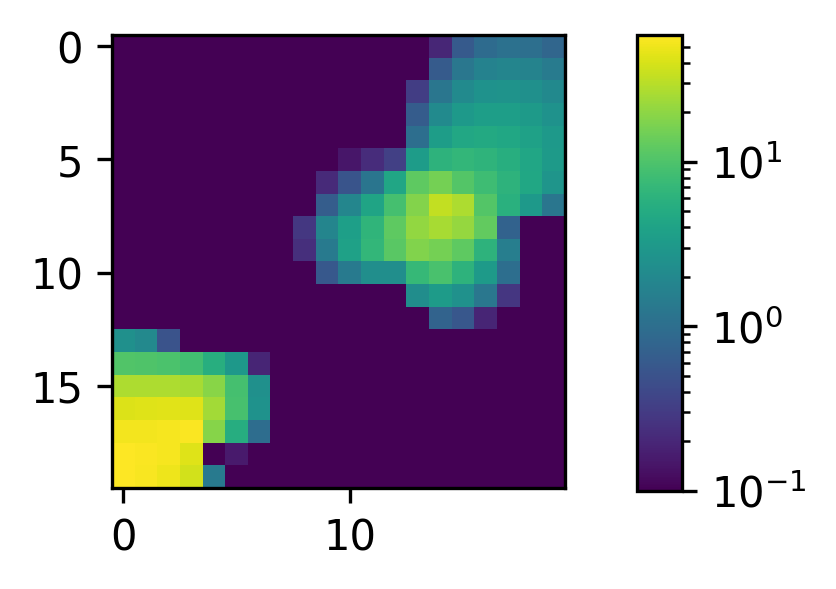

In [171]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df_refactored), norm=LogNorm(min(df_simpler.rainfall) + 0.1,
                                                               max(df_simpler.rainfall), clip=True))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)